In [56]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pickle
from keras.layers import Dropout
from tensorflow.keras import regularizers

In [19]:
path = '1661-0.txt'  # your file
with open(path, encoding='utf-8', errors='ignore') as f:
    text = f.read().lower()

print('corpus length:', len(text))

corpus length: 581888


In [20]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)
print('Total words:', len(words))

Total words: 109226


In [21]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [22]:
WORD_LENGTH = 5  # sequence length
prev_words = []
next_words = []

for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])

print('Example input sequence:', prev_words[0])
print('Example target word:', next_words[0])

Example input sequence: ['project', 'gutenberg', 's', 'the', 'adventures']
Example target word: of


In [23]:
vocab = sorted(list(set(words)))
word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for i, w in enumerate(vocab)}
vocab_size = len(vocab)
print('Vocabulary size:', vocab_size)

Vocabulary size: 8201


In [24]:
X = np.zeros((len(prev_words), WORD_LENGTH), dtype=np.int32)
Y = np.zeros((len(prev_words), vocab_size), dtype=np.bool_)

for i, seq in enumerate(prev_words):
    X[i] = [word_to_index[w] for w in seq]
    Y[i, word_to_index[next_words[i]]] = 1

In [92]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=WORD_LENGTH))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))  # dropout added
model.add(Dense(vocab_size))
#model.add(Dense(vocab_size, kernel_regularizer=regularizers.l2(0.0005)))
model.add(Activation('softmax'))

In [93]:
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [94]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X, Y,
    validation_split=0.05,
    batch_size=128,
    epochs=10,
    shuffle=True,
    callbacks=[early_stop]
).history

Epoch 1/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.0503 - loss: 7.3208 - val_accuracy: 0.0538 - val_loss: 7.2610
Epoch 2/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - accuracy: 0.0528 - loss: 6.5044 - val_accuracy: 0.0538 - val_loss: 7.1975
Epoch 3/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.0548 - loss: 6.3380 - val_accuracy: 0.0683 - val_loss: 7.1117
Epoch 4/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.0712 - loss: 6.2040 - val_accuracy: 0.0731 - val_loss: 7.0120
Epoch 5/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.0782 - loss: 6.0858 - val_accuracy: 0.0763 - val_loss: 6.9431
Epoch 6/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.0885 - loss: 6.0279 - val_accuracy: 0.0809 - val_loss: 6.9276
Epoch 7/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.0949 - loss: 5.9853 - val_accuracy: 0.0850 - val_loss: 6.9002
Epoch 8/10
811/811 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.1006 - loss: 5.9112 - 

In [95]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))

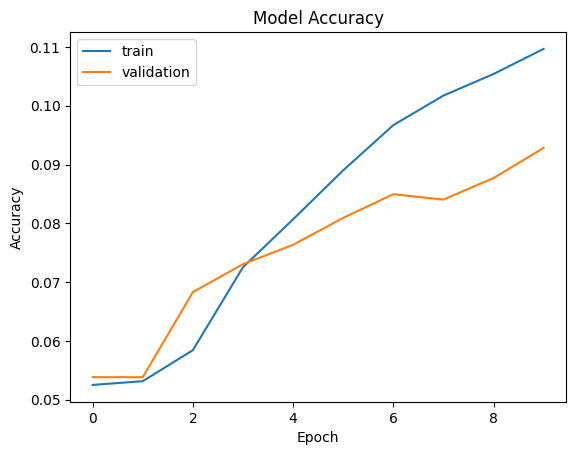

In [96]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

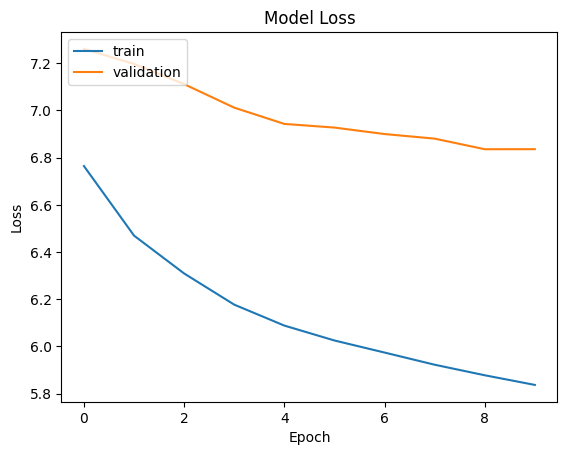

In [97]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [102]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [108]:
def predict_next_word_sampling(model, word_to_index, index_to_word, seed_text, WORD_LENGTH, temperature=1.0):
    token_list = seed_text.lower().split()[-WORD_LENGTH:]
    X_pred = np.zeros((1, WORD_LENGTH), dtype=np.int32)
    for i, w in enumerate(token_list):
        X_pred[0, i] = word_to_index.get(w, 0)
    
    predicted_probs = model.predict(X_pred, verbose=0)[0]
    predicted_probs = np.log(predicted_probs + 1e-8) / temperature
    exp_preds = np.exp(predicted_probs)
    predicted_probs = exp_preds / np.sum(exp_preds)
    
    next_index = np.random.choice(len(predicted_probs), p=predicted_probs)
    return index_to_word[next_index]

In [109]:
seed_text = "the adventures of sherlock"
next_word = predict_next_word(model, None, seed_text, word_to_index, index_to_word, WORD_LENGTH)
print(f"Seed text: '{seed_text}' → Predicted next word: '{next_word}'")

Seed text: 'the adventures of sherlock' → Predicted next word: 'and'
